In [18]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Preprocessing & evaluation
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# NN (Keras / TensorFlow)
import tensorflow as tf

# Pytorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [20]:
# Load dataset
PROCESSED_PATH = "Resaleflatprices_preprocessed.csv"
df = pd.read_csv(PROCESSED_PATH)

print("Shape:", df.shape)
df.head()

Shape: (216946, 16)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_num,storey_mid,remaining_lease_years,flat_age
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,2017,1,11.0,61.333333,37.666667
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,2017,1,2.0,60.583333,38.416667
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,2017,1,2.0,62.416667,36.583333
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,2017,1,5.0,62.083333,36.916667
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,2017,1,2.0,62.416667,36.583333


## Feature Selection + Train/Val/Test Split

In [24]:
FEATURES = [
    "town", "flat_type", "flat_model",             # categoricals
    "floor_area_sqm", "storey_mid", "flat_age"     # numeric
]
TARGET = "resale_price"

In [26]:
# Split dataset by year 
train_df = df[df["year"].between(2017, 2023)]
val_df   = df[df["year"] == 2024]
test_df  = df[df["year"] == 2025]

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

# Separate predictors and target
X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val,   y_val   = val_df[FEATURES], val_df[TARGET]
X_test,  y_test  = test_df[FEATURES], test_df[TARGET]


Train: (169150, 16) Val: (27832, 16) Test: (19964, 16)


## Tensorflow

In [45]:
# Preprocessing + model pipeline 
# Separate categorical and numeric features
categorical = ["town", "flat_type", "flat_model"]
numeric     = ["floor_area_sqm", "storey_mid", "flat_age"]

# ColumnTransformer lets us apply one-hot encoding only to categoricals and pass numeric features through unchanged.
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

In [47]:
# Fit on train only, transform all splits to NumPy
X_train_np = preprocess.fit_transform(X_train)
X_val_np   = preprocess.transform(X_val)
X_test_np  = preprocess.transform(X_test)

input_dim = X_train_np.shape[1]
input_dim

57

In [49]:
# Neural Network TF definition
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),       # input layer
    
    tf.keras.layers.Dense(256, activation="relu"),   # 1st hidden layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128, activation="relu"),   # 2nd hidden layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation="relu"),    # 3rd hidden layer
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation="linear")    # output layer (regression)
])

# Compile model (optimizer, loss, metrics)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mae",
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name="rmse"),
        tf.keras.metrics.MeanAbsoluteError(name="mae")
    ]
)

# Print model summary (layers, params)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,857 (226.00 KB)

 Trainable params: 56,961 (222.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [51]:
# Train TF model
history = model.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=150,        
    batch_size=64,    
    verbose=2          
)

Epoch 1/150
2643/2643 - 5s - 2ms/step - loss: 490623.9375 - mae: 490623.9375 - rmse: 519190.8125 - val_loss: 611616.9375 - val_mae: 611616.9375 - val_rmse: 640031.3125
Epoch 2/150
2643/2643 - 3s - 1ms/step - loss: 488922.1562 - mae: 488922.1562 - rmse: 517578.5938 - val_loss: 609299.6875 - val_mae: 609299.6875 - val_rmse: 637804.3750
Epoch 3/150
2643/2643 - 3s - 1ms/step - loss: 486077.2500 - mae: 486077.2500 - rmse: 514887.7812 - val_loss: 605948.5625 - val_mae: 605948.5625 - val_rmse: 634607.3750
Epoch 4/150
2643/2643 - 3s - 1ms/step - loss: 482232.6875 - mae: 482232.6875 - rmse: 511259.9375 - val_loss: 601645.5625 - val_mae: 601645.5625 - val_rmse: 630493.2500
Epoch 5/150
2643/2643 - 3s - 1ms/step - loss: 477420.4062 - mae: 477420.4062 - rmse: 506725.2188 - val_loss: 596309.1250 - val_mae: 596309.1250 - val_rmse: 625415.3750
Epoch 6/150
2643/2643 - 3s - 1ms/step - loss: 471654.5000 - mae: 471654.5000 - rmse: 501306.0000 - val_loss: 590067.8750 - val_mae: 590067.8750 - val_rmse: 6194

In [53]:
# Define function to evaluate model
def evaluate_model_nn(model, X_train_np, y_train, X_val_np, y_val, model_name):
    # Predict
    y_train_pred = model.predict(X_train_np, verbose=0).reshape(-1)
    y_val_pred   = model.predict(X_val_np,   verbose=0).reshape(-1)

    # Train metrics
    mae_train  = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train   = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

    # Val metrics
    mae_val  = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

    return {
        "model": model_name,
        "train": {"MAE": mae_train, "RMSE": rmse_train, "R2": r2_train, "MAPE": mape_train},
        "val":   {"MAE": mae_val,   "RMSE": rmse_val,   "R2": r2_val,   "MAPE": mape_val},
        "y_val_pred": y_val_pred
    }

# Define function to print results
def print_results(results):
    print(f"{results['model']} Evaluation:")

    print("\nTrain Results:")
    print(f"MAE : {results['train']['MAE']:,.0f}")
    print(f"RMSE: {results['train']['RMSE']:,.0f}")
    print(f"R²  : {results['train']['R2']:.3f}")
    print(f"MAPE: {results['train']['MAPE'] * 100:.2f}%")

    print("\nValidation Results:")
    print(f"MAE : {results['val']['MAE']:,.0f}")
    print(f"RMSE: {results['val']['RMSE']:,.0f}")
    print(f"R²  : {results['val']['R2']:.3f}")
    print(f"MAPE: {results['val']['MAPE'] * 100:.2f}%")

# Define function to plot scatterplot
def plot_scatterplot(y_true, y_pred, title):
    plt.figure(figsize=(7,7))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()], "r--")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(title)
    plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()


In [55]:
# Evaluate on train & val 
nn_results = evaluate_model_nn(
    model,
    X_train_np, y_train,
    X_val_np,   y_val,
    "TF"
)
print_results(nn_results)

TF Evaluation:

Train Results:
MAE : 37,717
RMSE: 52,927
R²  : 0.903
MAPE: 7.83%

Validation Results:
MAE : 84,106
RMSE: 109,038
R²  : 0.666
MAPE: 13.08%


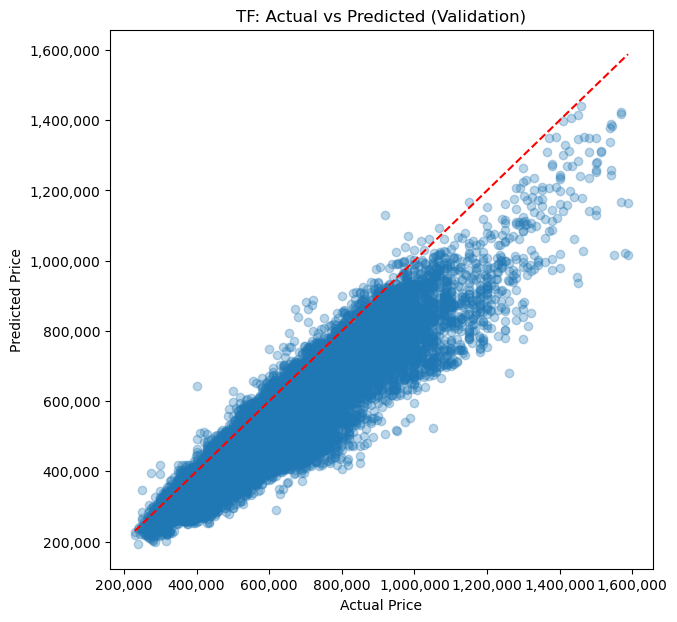

In [57]:
# Scatter plot on validation
plot_scatterplot(
    y_val,
    nn_results["y_val_pred"],
    title="TF: Actual vs Predicted (Validation)"
)

In [59]:
# Evaluate on test set
y_test_pred = model.predict(X_test_np, verbose=0).reshape(-1)
mae  = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2   = r2_score(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("TF Test Results:")
print(f"MAE : {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²  : {r2:.3f}")
print(f"MAPE: {mape * 100:.2f}%")


TF Test Results:
MAE : 117,598
RMSE: 142,290
R²  : 0.502
MAPE: 17.43%


## Pytorch

In [64]:
# Force CPU
device = torch.device("cpu")

# Convert your preprocessed arrays to tensors (float32), targets as (N,1)
X_tr = torch.tensor(X_train_np.astype(np.float32), dtype=torch.float32)
y_tr = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)

X_va = torch.tensor(X_val_np.astype(np.float32), dtype=torch.float32)
y_va = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)

X_te = torch.tensor(X_test_np.astype(np.float32), dtype=torch.float32)
y_te = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# DataLoader for training 
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)

In [66]:
# Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.20),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.20),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 1),  # regression output
            nn.Softplus() 
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_tr.shape[1]
pt_model = MLP(input_dim).to(device)

In [68]:
# Optimizer + loss 
optimizer = torch.optim.Adam(pt_model.parameters(), lr=1e-3)
criterion = nn.L1Loss()  # MAE

In [70]:
# Train loop 
epochs = 150
for epoch in range(epochs):
    pt_model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad(set_to_none=True)
        preds = pt_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    if (epoch + 1) % 10 == 0:
        avg_mae = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Train MAE: {avg_mae:.2f}")

Epoch 10/150 | Train MAE: 428796.78
Epoch 20/150 | Train MAE: 254332.82
Epoch 30/150 | Train MAE: 68612.91
Epoch 40/150 | Train MAE: 51736.73
Epoch 50/150 | Train MAE: 49312.95
Epoch 60/150 | Train MAE: 48139.89
Epoch 70/150 | Train MAE: 47504.65
Epoch 80/150 | Train MAE: 46714.92
Epoch 90/150 | Train MAE: 46363.44
Epoch 100/150 | Train MAE: 45939.73
Epoch 110/150 | Train MAE: 45640.75
Epoch 120/150 | Train MAE: 45293.93
Epoch 130/150 | Train MAE: 45066.97
Epoch 140/150 | Train MAE: 45128.76
Epoch 150/150 | Train MAE: 44838.95


In [78]:
def evaluate_model_nn_pt(model, X_train_t, y_train, X_val_t, y_val, model_name):
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train_t).cpu().numpy().reshape(-1)
        y_val_pred   = model(X_val_t).cpu().numpy().reshape(-1)

    mae_train  = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train   = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

    mae_val  = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

    return {
        "model": model_name,
        "train": {"MAE": mae_train, "RMSE": rmse_train, "R2": r2_train, "MAPE": mape_train},
        "val":   {"MAE": mae_val,   "RMSE": rmse_val,   "R2": r2_val,   "MAPE": mape_val},
        "y_val_pred": y_val_pred
    }

PyTorch Evaluation:

Train Results:
MAE : 39,088
RMSE: 54,378
R²  : 0.897
MAPE: 8.14%

Validation Results:
MAE : 86,738
RMSE: 110,578
R²  : 0.656
MAPE: 13.42%


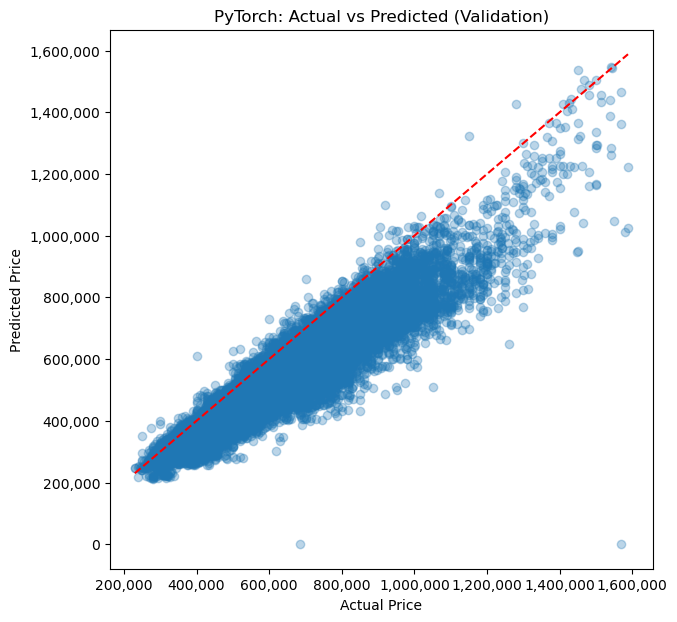

In [80]:
# Evaluate 
pt_results = evaluate_model_nn_pt(pt_model, X_tr, y_train, X_va, y_val, "PyTorch")
print_results(pt_results)
plot_scatterplot(y_val, pt_results["y_val_pred"], "PyTorch: Actual vs Predicted (Validation)")

In [82]:
# Test evaluation 
with torch.no_grad():
    y_test_pred = pt_model(X_te).cpu().numpy().reshape(-1)

mae  = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2   = r2_score(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\nPyTorch Test Results:")
print(f"MAE : {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²  : {r2:.3f}")
print(f"MAPE: {mape * 100:.2f}%")


PyTorch Test Results:
MAE : 119,710
RMSE: 142,906
R²  : 0.498
MAPE: 17.69%
